In [4]:
import pandas as pd

party_replace = {
    'PARTI KEADILAN RAKYAT (PKR)': 'PAKATAN HARAPAN (PH)',
    'PARTI TINDAKAN DEMOKRATIK (DAP)': 'PAKATAN HARAPAN (PH)',
    'PARTI ISLAM SE MALAYSIA (PAS)': 'PERIKATAN NASIONAL (PN)',
    'IKATAN DEMOKRATIK MALAYSIA (MUDA)': 'PAKATAN HARAPAN (PH)'
}

df = pd.read_csv('data/candidates_ge15.csv',usecols=['state','parlimen','party','name_display','result'])
df.party = df.party.replace(party_replace).fillna(df.party)
df = df[df.result == 1].drop('result',axis=1)
n_seats = df[['party']].groupby('party').size()
df = df[~df.state.isin(['Sabah','Sarawak','W.P. Labuan'])] # to add East Msia, comment out this line
df.party = df.party.map(party_replace).fillna(df.party)
df['party_short'] = df.party.str.extract(r'\((\w+)\)')
party_abbr = dict(zip(df.party,df.party_short))
df = df.drop('party_short',axis=1)

var_demog = 'income_avg' # change at will - there's quite a bit of stuff in the census data
ef = pd.read_csv('data/census_parlimen.csv',usecols=['state','parlimen',var_demog])

df = pd.merge(df,ef,on=['state','parlimen'],how='left')
assert len(df[df[var_demog].isnull()]) == 0, 'Missing data!' # ensure complete merge
demog_mean = (df[['party',var_demog]].groupby('party').mean()).to_dict()
df = df.sort_values(by=var_demog).reset_index(drop=True)
df['plot'] = 1
df

,state,parlimen,name_display,party,income_avg,plot
0,Kelantan,P.030 Jeli,POK ZAHARI,PERIKATAN NASIONAL (PN),3750,1
1,Perak,P.073 Pasir Salak,USTAZ JAMALUDIN BIN YAHYA,PERIKATAN NASIONAL (PN),3780,1
2,Kelantan,P.023 Rantau Panjang,KAK LAH,PERIKATAN NASIONAL (PN),3864,1
3,Perak,P.055 Lenggong,DR SHAMSUL ANUAR NASARAH,BARISAN NASIONAL (BN),3885,1
4,Kelantan,P.032 Gua Musang,MOHD AZIZI ABU NAIM,PERIKATAN NASIONAL (PN),3918,1
...,...,...,...,...,...,...
160,W.P. Kuala Lumpur,P.122 Seputeh,TERESA KOK,PAKATAN HARAPAN (PH),13489,1
161,Selangor,P.108 Shah Alam,AZLI YUSOF,PAKATAN HARAPAN (PH),13567,1
162,Selangor,P.099 Ampang,RODZIAH ISMAIL,PAKATAN HARAPAN (PH),13591,1
163,W.P. Kuala Lumpur,P.120 Bukit Bintang,FONG KUI LUN,PAKATAN HARAPAN (PH),13677,1


PH is coloured in red. They won 82 seats, with an avg income of RM8,905.
PN is coloured in grey. They won 74 seats, with an avg income of RM5,794.
BN is coloured in blue. They won 30 seats, with an avg income of RM6,044.


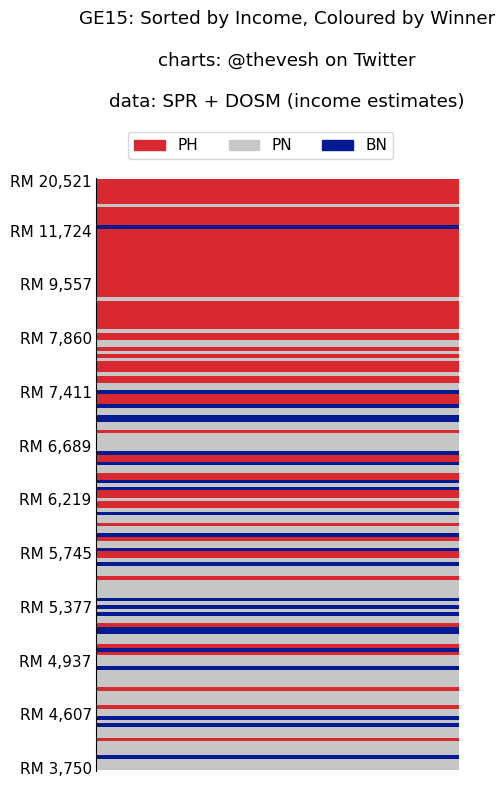

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as tkr
import numpy as np


party_color = { # colors from SPR dashboard
    'PAKATAN HARAPAN (PH)':'#d7292f',
    'PERIKATAN NASIONAL (PN)':'#c6c6c6', # to ensure no red-green colour-blind clash
    'BARISAN NASIONAL (BN)':'#031a93',
    'GABUNGAN PARTI SARAWAK (GPS)': '#1f2c45',
    'PARTI GABUNGAN RAKYAT SABAH (GRS)': '#5bc5f0',
    'PARTI WARISAN SABAH (WARISAN)': '#5bc5f0',
    'BEBAS (BEBAS)': '#000000', 
    'PARTI KESEJAHTERAAN DEMOKRATIK MASYARAKAT (KDM)': '#000000',
    'PARTI BANGSA MALAYSIA (PBM)': '#000000'
}

party_color_desc = { # colors from SPR dashboard
    'PAKATAN HARAPAN (PH)':'red',
    'PERIKATAN NASIONAL (PN)':'grey', # to ensure no red-green colour-blind clash
    'BARISAN NASIONAL (BN)':'blue',
    'GABUNGAN PARTI SARAWAK (GPS)': 'dark greyish blue',
    'PARTI GABUNGAN RAKYAT SABAH (GRS)': 'light blue',
    'PARTI WARISAN SABAH (WARISAN)': 'light blue',
    'BEBAS (BEBAS)': 'black', 
    'PARTI KESEJAHTERAAN DEMOKRATIK MASYARAKAT (KDM)': 'black',
    'PARTI BANGSA MALAYSIA (PBM)': 'black'
}

n_parties = 3
df['color'] = df.party.map(party_color)
selected_parties = list(party_color.keys())[:n_parties]

plt.rcParams.update({'font.size': 11,
                     'font.family': 'sans-serif',
                     'grid.linestyle': 'dashed'})
plt.rcParams["figure.figsize"] = [5,8]
plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots()

y_labels = df[df.party.isin(selected_parties)][var_demog].tolist()
y_labels_keep = [0+15*x for x in range(11)] + [164]
def filter_label(str, i): return str if i in y_labels_keep else ''
y_labels = [filter_label(f'RM {np.round(y_labels[i],0):,.0f}', i) for i in range(len(y_labels))]

df[df.party.isin(selected_parties)].plot(kind='barh', width=1, y='plot', edgecolor='black', lw=0,
                color=df[df.party.isin(selected_parties)].color.tolist(), ax=ax, legend=False)
ax.set_title(f'GE15: Sorted by Income, Coloured by Winner\n\ncharts: @thevesh on Twitter\n\ndata: SPR + DOSM (income estimates)\n\n\n')
for p in ['top','bottom','right']: ax.spines[p].set_visible(False)
ax.set_yticklabels(y_labels)
ax.set_ylabel('')
ax.axes.get_xaxis().set_visible(False)
ax.set_axisbelow(True)
ax.tick_params(length=0)


patches = [mpatches.Patch(color=party_color[p], label=f'{party_abbr[p]}') for p in selected_parties]
ax.legend(handles=patches,labelspacing = 1.5, ncol=3, bbox_to_anchor=(0.8,1.09))

# ALT text
for p in list(party_color.keys())[:n_parties]: 
    print(f"""\
{p[-3:-1]} is coloured in {party_color_desc[p]}. \
They won {n_seats[p]} seats, with an avg income of RM{demog_mean[var_demog][p]:,.0f}.\
""")